# IMPORTAMOS LAS LIBRERIAS

In [1]:
import tensorflow as tf
import gym
from gym import envs
import numpy as np

# DEFINIMOS EL ENTORNO DEL GYM DE OPENAI QUE QUEREMOS USAR

## Características del entorno:

- Recibimos +1 de recompensa por cada step que el palo se encuentra recto encima de la base
- Reseteamos el entorno si el palo pasa de 15 grados a derecha o izquierda y si la base se sale del mapa

 

In [2]:
env_name = "CartPole-v0"

# PROBAMOS EL ENTORNO

In [3]:
#Iteramos interations para probar el entorno y que no hay problemas de compatibilidad
def test_environment(iterations):
    env = gym.make(env_name)   
    
    #el action space son el numero de accciones que puede realizar el agente y puede ser continuo o discreto
    print(env.action_space)
    #el observation_space son las observaciones que tiene el agente y pueden ser continuas o discretas
    print(env.observation_space)
    
    env.reset()
    
    #este es el codigo basico que nos proporciona openAI para usar su modulo gym
    for j in range(iterations):
        env.render()
        new_state, _, done,_ = env.step(env.action_space.sample()) # take a random action
        
        if done:
            env.reset()
    
    env.close()

In [4]:
#efectivamente aqui podemos comprobar que las acciones son discretas y son dos, moverse a la derecha o izquierda, -1,1
#en cambio las observaciones son continuas, y son angulos a derecha e izquierda del palo y la distancia a izquierda y derecha del escenario
test_environment(50)

C:\Anaconda\envs\tf-gpu\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Discrete(2)
Box(4,)


# CREAMOS EL ENTORNO

In [5]:
env = gym.make(env_name) 
#env = env.unwrapped    #SI USAMOS EL UNWRAPPED DEL ENTORNO QUITAREMOS EL LÍMITE DE 200 PASOS POR EPISODIO 
env.seed(5) 

[5]

# DEFINIMOS LOS HIPERPARAMETROS

In [6]:
dims = env.observation_space.shape

observation_size = dims[0]
action_size = env.action_space.n

max_episodes = 2000
learning_rate = 0.01  #suele ser un buen valor
gamma = 0.98         #discount factor para el extended reward
training = True
render_env_training = True  #queremos renderizar mientras entrenamos?

# CALCULAMOS EL DISCOUNTED REWARD

In [7]:
#En este algoritmo utilizamos el valor del estado para calcular la función de perdida y asi poder optimizar el modelo
#Es decir, simulamos todo el episodio y guardamos las recompensas de cada paso. 
#Una vez las tenemos aplicamos el factor de descuento a cada una,
#dando asi mas prioridad a las cercanas del estado del que partimos.
#Aplicado el discount factor utilizamos técnicas estadísticas como la media y la desviación típica para 
#desechar mediciones que no sean utiles

def calculate_discounted_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards -mean) / (std)
    
    return discounted_episode_rewards

# ESTRUCTURA DE RED NEURONAL
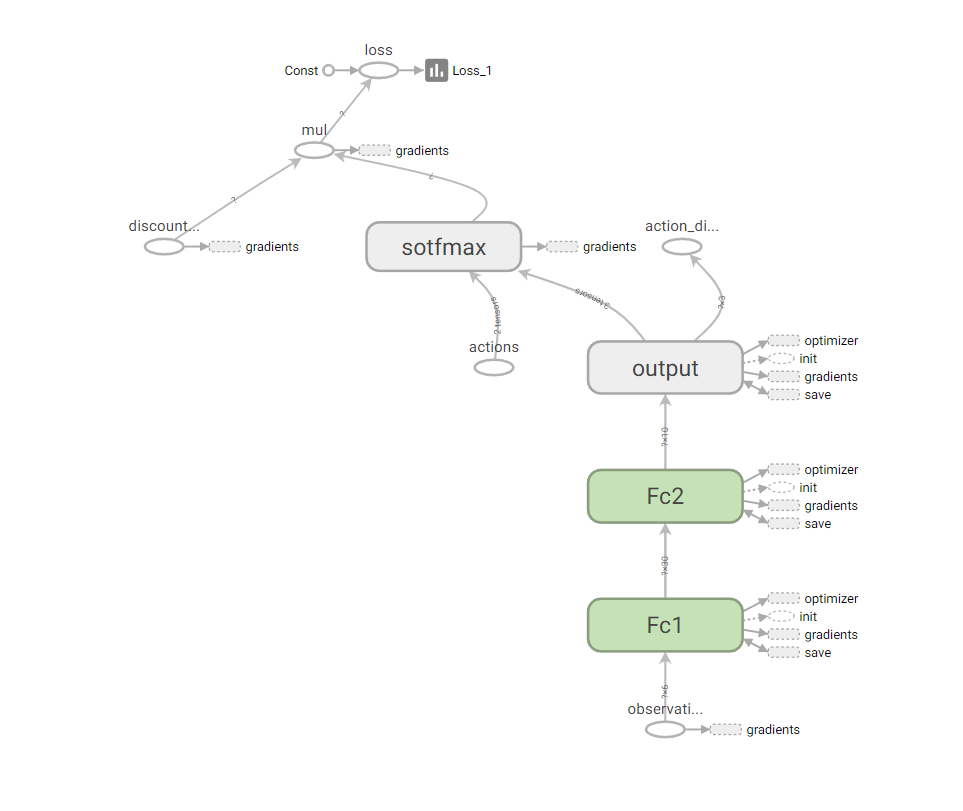

In [8]:
#creamos una clase que contiene nuestra estructura de red neuronal
#Variables de entrada, 3 capas de nueronas, una funcion softmax para probabilidades y softmax crossentropy para clasificacion

class PolicyGradient():
    
    def __init__(self):
        self.observations = tf.placeholder(shape=(None,observation_size),dtype = tf.float32, name = "observations")
        self.actions = tf.placeholder(shape = (None, action_size), dtype = tf.float32, name = "actions")
        self.discounted_rewards_ = tf.placeholder(shape = (None,), dtype=tf.float32, name = "discounted_episodes_rewards")

        #usamos esta variable para visualizar en tensorboard
        self.mean_reward_ = tf.placeholder(tf.float32 , name="mean_reward")

        #2 FULLY CONNECTED LAYERS CON RELU COMO ACTIVACION Y EL OUTPUT
        #EN CUANTO AL NUMERO DE NEURONAS EN FC1 HE PROBADO 512, 100, 50 Y 10
        #CON DIFERENCIA LA QUE MEJORES RESULTADO DA Y LA QUE ANTES CONVERGE ES 10
        self.fc1 = tf.layers.dense(inputs=self.observations, units=10,activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(),name="Fc1")

        self.fc2 = tf.layers.dense(inputs=self.fc1, units= action_size, activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(), name = "Fc2")

        self.output = tf.layers.dense(inputs=self.fc2, units = action_size, activation= None, kernel_initializer=tf.contrib.layers.xavier_initializer(), name = "output")

        self.action_distribution = tf.nn.softmax(self.output, name= "action_distribution")

        self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.output, labels = self.actions, name = "sotfmax")
        self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_rewards_, name = "loss") 
        
        #ADAM ES UNA VARIANTE DEL GRADIENT DESCENT, QUE SE ADAPTA EN CADA PASO A LA FUNCION DE COSTE
        #PARA MAS INFO: https://www.youtube.com/watch?v=nhqo0u1a6fw
        self.train_opt = tf.train.AdamOptimizer(learning_rate,name="optimizer").minimize(self.loss)

In [9]:
#CREAMOS NUESTRA RED NEURONAL.
tf.reset_default_graph()
policy = PolicyGradient()

 # Visualizacion en tensorboard

 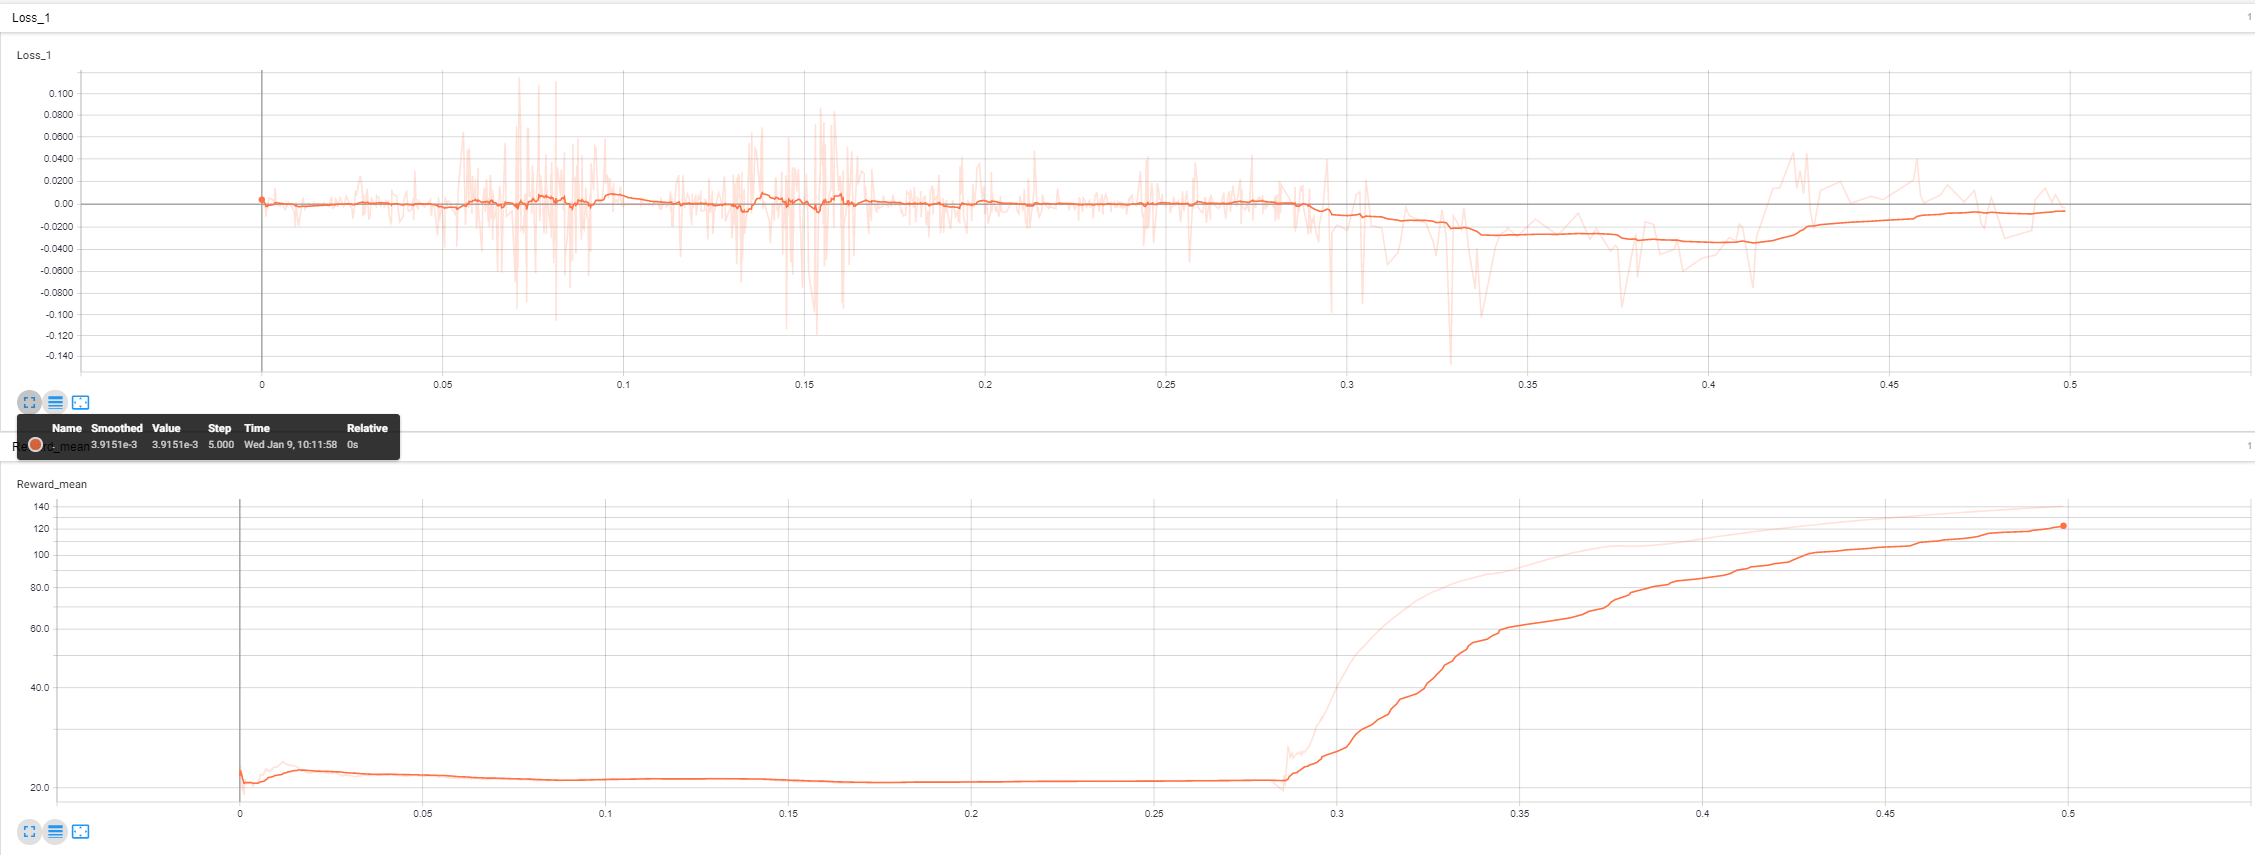

In [10]:
#Opcionalmente podemos usar tensorboard para ver el progreso de nuestro algoritmo
writer = tf.summary.FileWriter("./tensorboard/pg/" + env_name)

tf.summary.scalar("Loss", policy.loss)
tf.summary.scalar("Reward_mean", policy.mean_reward_)

write_op = tf.summary.merge_all()

In [11]:
allRewards = []  #las recompensas de todos los episodios
total_rewards = 0  #la suma de las recompensas de los episodios
maximumRewardRecorded = 0  #la puntuacion del episodio más alta
episode = 0

episode_states, episode_actions, episode_rewards = [],[],[] #datos del episodio una vez simulado con montecarlo

saver = tf.train.Saver(save_relative_paths = True)

if training:
    with tf.Session() as sess: #iniciamos una sesion en tensorflow
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)
        
        #las iteraciones para optimizar nuestra politica
        for episode in range(max_episodes):
            episodes_rewards_sum = 0
            state = env.reset()

            #simulamos hasta que se acabe el episodio
            while True:
                
                if render_env_training:
                    env.render()
                    
                #conseguimos las probabilidades de las acciones segun la politica
                action_prob_distribution = sess.run(policy.action_distribution, feed_dict = {policy.observations: state.reshape([1,observation_size])})
                action = np.random.choice(range(action_prob_distribution.shape[1]), p = action_prob_distribution.ravel())

                #realizamos esas acciones y guardamos la informacion del estado, accion y recompensa en sus respectivos arrays
                new_state, reward, done, info = env.step(action)
                    
                #guardamos la informacion importante del episodio en su sitio
                episode_states.append(state)
                action_ = np.zeros(action_size)
                action_[action] = 1
                episode_actions.append(action_)
                episode_rewards.append(reward)

                #cuando ha acabado el episodio calculamos la función de score teniendo en cuenta las recompensas
                if done:
                    episode_rewards_sum = np.sum(episode_rewards)
                    allRewards.append(episode_rewards_sum)
                    total_rewards = np.sum(allRewards)

                    mean_reward = np.divide(total_rewards,episode+1)
                    maximumRewardRecorded = np.amax(allRewards)

                    print("======================================")
                    print('Episode: ',episode)
                    print('Episode reward sum:  ', episode_rewards_sum)
                    print('Mean reward: ', mean_reward)
                    print('Maximum reward: ',maximumRewardRecorded)

                    discounted_episode_rewards = calculate_discounted_rewards(episode_rewards)

                    #pasamos los datos, calculamos gradientes y backprop
                    loss_, _ = sess.run([policy.loss, policy.train_opt], feed_dict={policy.observations: np.vstack(np.array(episode_states)),
                                                                     policy.actions: np.vstack(np.array(episode_actions)),
                                                                     policy.discounted_rewards_: discounted_episode_rewards})



                    #Le pasamos la información a tensorboard
                    summary = sess.run(write_op, feed_dict={policy.observations: np.vstack(np.array(episode_states)),
                                                            policy.actions: np.vstack(np.array(episode_actions)),
                                                            policy.discounted_rewards_: discounted_episode_rewards,
                                                            policy.mean_reward_: mean_reward})

                    writer.add_summary(summary, episode)
                    writer.flush()

                    # reseteamos las listas para calcular los expected rewards
                    episode_states, episode_actions, episode_rewards = [],[],[]

                    break

                state = new_state
                
            #guardamos el modelo cada 10 iteraciones
            if episode % 10 == 0:
                print("Saving Model")
                save_path = saver.save(sess, "./models/" + env_name + "/" + env_name)